## AutoEncoder

libraries

In [1]:
# Data Wrangling
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.preprocessing import PolynomialFeatures

# Modeling
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.ensemble import VotingClassifier
from vecstack import stacking
from scipy.stats.mstats import gmean

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import ShuffleSplit

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
from sklearn.externals import joblib
import pickle
from itertools import combinations
import gc
from tqdm import tqdm
import platform

# Keras
import tensorflow as tf
# Tensorflow warning off
if tf.__version__[0] < '2':
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    tf.logging.set_verbosity(tf.logging.ERROR)
import keras
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.constraints import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot
from keras.preprocessing.image import *
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import *

from keras.models import Model, Sequential
from keras import Input
from keras import layers
from keras.optimizers import RMSprop
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping


Using TensorFlow backend.


read data

In [253]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()


transform data

In [254]:
y_train = pd.read_csv('y_train.csv').gender
# AE는 PCA와 유사하게 sparse한 데이터에 먹힌다
# -> 구매여부 외 구매건수도 적용하여 볼 수 있겠음.


# < 물품 구매여부 >
# 중분류
level = 'gds_grp_nm'
train_test1 = pd.pivot_table(pd.concat([df_train, df_test]), index='cust_id', columns=level, values='amount',
                           aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0).reset_index()
# 대분류
level = 'gds_grp_mclas_nm'
train_test2 = pd.pivot_table(pd.concat([df_train, df_test]), index='cust_id', columns=level, values='amount',
                           aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0).reset_index()

# 소분류
level = 'goods_id'
train_test3 = pd.pivot_table(pd.concat([df_train, df_test]), index='cust_id', columns=level, values='amount',
                            aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0).reset_index()


train_test = pd.merge(train_test1, train_test2, on='cust_id')
train_test = pd.merge(train_test, train_test3, on='cust_id')
train = train_test.query('cust_id not in @IDtest').drop('cust_id', axis=1)
test = train_test.query('cust_id in @IDtest').drop('cust_id', axis=1)

train.shape, test.shape

((3500, 4179), (2482, 4179))

operate AE

Model: "AE_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        (None, 4179)              0         
_________________________________________________________________
dense_440 (Dense)            (None, 512)               2140160   
_________________________________________________________________
dense_441 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_442 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_443 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_444 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_445 (Dense)            (None, 256)               330

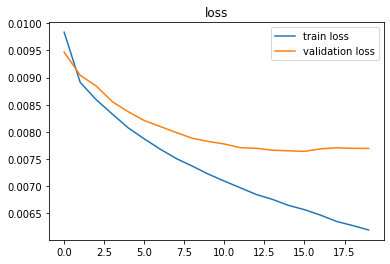

In [257]:
# add dropout
#inputs_drop = Dropout(0.3)(input_dim)
# add gaussian noise

feature_nums = train.shape[1] # 피쳐개수
encoding_dim = 128 # 몇차원으로 줄일지
input_dim = Input(shape=(feature_nums, )) # 입력 피쳐의 형태

# Encoding
# noise_level = 1.0
# inputs_noisy = (noise_level * np.random.normal(0,1,train.shape[1]))(input_dim)


encoded1 = Dense(512, activation ='relu')(input_dim)
encoded2 = Dense(256, activation ='relu')(encoded1)
encoded3 = Dense(128, activation ='relu')(encoded2)
encoded4 = Dense(encoding_dim, activation ='relu')(encoded3)
# Decoding
decoded1 = Dense(128, activation ='relu')(encoded4)
decoded2 = Dense(256, activation ='relu')(decoded1)
decoded3 = Dense(512, activation ='relu')(decoded2)
decoded4 = Dense(feature_nums, activation ='linear')(decoded3)
# -> 마지막은 입력층과 값이 같아야 한다: feature_nums
# linear 대신 sortmax와 binary crossentropy 써도 됨.

# Combine encoder and decoder layers
autoencoder = Model(inputs = input_dim, outputs = decoded4, name='AE_model')
autoencoder.summary()

# Compile the model
autoencoder.compile(optimizer = 'adam', loss='mse', metrics=['acc'])

# Train the model
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]
hist = autoencoder.fit(train, train, epochs=20, batch_size=64,
                      shuffle=True, validation_data=(test,test),)
                      #callbacks=callbacks)

plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.legend()
plt.title('loss')
plt.show()

In [258]:
# extract hidden layer features

hidden_act = [encoded4]
for ix, act in enumerate(hidden_act):
    model = Model(inputs = input_dim, outputs=act)
    if ix == 0:
        X_train = model.predict(train)
        X_test = model.predict(test)
    else:
        X_train = np.hstack([X_train, model.predict(train)])
        X_test = np.hstack([X_test, model.predict(test)])
        
X_train.shape, X_test.shape

((3500, 128), (2482, 128))

bulid models again

In [265]:
pd.DataFrame(X_train)
pd.DataFrame(X_test)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,1.231252,0.0,0.596623,1.039953,1.056052,0.0,0.0,0.731154,0.0,0.0,...,0.0,0.713546,0.745418,0.0,0.844641,1.051376,0.0,0.428479,0.901630,0.000000
1,1.510906,0.0,0.063037,1.684502,0.648636,0.0,0.0,0.889263,0.0,0.0,...,0.0,1.286544,1.285653,0.0,0.000000,0.941839,0.0,0.079361,1.171832,0.000000
2,0.189763,0.0,2.547615,0.000000,2.125732,0.0,0.0,2.555830,0.0,0.0,...,0.0,2.538195,2.056267,0.0,1.356012,0.548450,0.0,0.000000,1.610411,0.000000
3,0.654936,0.0,0.533129,0.475112,0.594944,0.0,0.0,0.405723,0.0,0.0,...,0.0,0.434279,0.901249,0.0,0.736964,0.713507,0.0,0.059004,0.535791,0.069910
4,0.568424,0.0,0.235693,0.184437,0.543289,0.0,0.0,0.412044,0.0,0.0,...,0.0,0.685626,0.706614,0.0,0.387471,0.802730,0.0,0.185956,0.385336,0.148161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,1.016448,0.0,0.394391,0.864921,0.468363,0.0,0.0,0.272054,0.0,0.0,...,0.0,0.523488,0.685800,0.0,0.264228,0.652557,0.0,0.359029,0.432391,0.000000
2478,0.110444,0.0,0.151739,0.268395,0.201195,0.0,0.0,0.028545,0.0,0.0,...,0.0,0.042006,0.182011,0.0,0.204874,0.045240,0.0,0.076572,0.121077,0.000000
2479,1.565616,0.0,0.533545,1.522751,1.670664,0.0,0.0,0.630488,0.0,0.0,...,0.0,1.277638,1.310861,0.0,0.393891,1.137524,0.0,0.611516,1.608379,0.000000
2480,0.975966,0.0,0.329679,1.031538,0.000000,0.0,0.0,0.285479,0.0,0.0,...,0.0,0.690295,0.822093,0.0,0.867131,0.605547,0.0,0.562134,0.155608,0.000000


In [285]:
train_w2v_f2 = pd.read_csv('X_train_after_percentile_nm&mclas2.csv',encoding='cp949')
test_w2v_f2 = pd.read_csv('X_test_after_percentile_nm&mclas2.csv',encoding='cp949')

In [260]:
train_w2v_f = pd.read_csv('X_train_after_percentile_nm&mclas.csv',encoding='cp949')
test_w2v_f = pd.read_csv('X_test_after_percentile_nm&mclas.csv',encoding='cp949')

In [ ]:
pd.DataFrame(X_train)

In [268]:
train_w2v_f

,0,1,2,3,4,5,6,7,8,9,...,256,257,258,259,260,261,262,263,264,265
0,5.977337e-02,6.151699e-02,6.736158e-02,5.591807e-02,3.984869e-02,6.069313e-02,6.897703e-02,5.745252e-02,4.763285e-02,0.060051,...,0.029223,-0.001905,-0.035456,-0.021344,0.149612,0.031331,0.257551,0.015236,0.104851,-0.025511
1,1.365995e-02,5.761599e-02,6.463000e-02,6.318288e-02,5.447783e-02,2.278225e-02,2.748601e-02,3.078676e-02,2.655345e-02,0.026076,...,-0.031597,0.105457,-0.135175,-0.011059,-0.181906,0.040177,-0.367597,0.387911,-0.176044,0.011116
2,3.497547e-03,5.263007e-02,3.574232e-03,6.179401e-05,1.452202e-02,2.454717e-02,2.496620e-02,2.627401e-02,1.097601e-02,0.010620,...,-0.017810,0.007759,-0.097820,-0.162288,-0.452104,0.292490,0.068061,0.386233,-0.054269,0.179784
3,4.250513e-02,3.941661e-02,2.824801e-02,4.400417e-02,3.688942e-02,5.410677e-02,3.160908e-02,6.179994e-02,4.185728e-02,0.042664,...,0.025322,-0.013239,-0.031842,-0.052557,0.237949,0.085064,0.331622,0.149253,0.164987,0.106727
4,5.702126e-02,5.004024e-02,8.137117e-02,4.469287e-02,1.178961e-02,2.243617e-02,8.216921e-02,4.900240e-02,6.015503e-02,0.041257,...,0.031552,0.004871,-0.012680,0.095767,0.056328,0.066425,0.379409,-0.107879,0.112735,-0.069668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3.607101e-02,1.636153e-02,1.173026e-02,7.821802e-03,3.840035e-02,4.302986e-02,4.711241e-03,8.589006e-03,1.499849e-02,0.002723,...,0.031584,0.014085,-0.035005,-0.034020,-0.170445,-0.099762,0.218327,0.145438,0.044994,0.022955
3496,6.030129e-02,3.547876e-02,5.457724e-02,7.359145e-02,5.336193e-02,4.219899e-02,3.772581e-02,3.719372e-02,2.389350e-02,0.027022,...,0.061646,0.001303,-0.049178,-0.088484,0.018275,-0.069989,0.321723,-0.086794,0.075755,-0.102090
3497,9.313226e-10,0.000000e+00,1.490116e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.725290e-09,0.000000,...,0.046136,-0.073397,0.109658,0.027255,-0.082981,-0.269622,0.040199,-0.225935,-0.022527,-0.119609
3498,0.000000e+00,1.862645e-09,0.000000e+00,1.396984e-09,7.450581e-09,5.587935e-09,2.980232e-08,1.117587e-08,0.000000e+00,0.000000,...,0.040525,0.000952,-0.005899,0.187429,0.212399,-0.173167,0.504306,-0.483753,0.140621,-0.261204


In [286]:
train_w2v_f2

,0,1,2,3,4,5,6,7,8,9,...,1171,1172,1173,1174,1175,1176,1177,1178,1179,1180
0,5.899665e-02,5.280996e-02,4.896489e-02,4.692144e-02,5.887605e-02,3.703730e-02,4.528708e-02,0.056775,4.558063e-02,4.952119e-02,...,-0.156888,-0.105949,-0.155277,-0.097476,0.177814,0.056659,0.250375,0.015539,0.103248,-0.034322
1,4.440968e-02,3.742162e-02,5.923415e-02,2.783321e-02,2.523422e-02,7.106267e-03,3.267865e-02,0.005263,2.856833e-02,7.226545e-02,...,-0.156888,-0.077582,-0.129688,-0.097476,-0.178935,0.045230,-0.403775,0.367147,-0.165190,0.053595
2,3.381081e-02,8.462013e-03,8.081478e-02,3.126807e-03,3.733460e-02,4.156350e-02,6.252491e-02,0.003031,3.383411e-02,2.499662e-02,...,-0.007472,-0.013615,-0.054837,-0.013450,-0.432448,0.273241,0.068090,0.392857,-0.038744,0.191552
3,4.476567e-02,3.724468e-02,6.270374e-02,3.711123e-02,4.323265e-02,3.776972e-02,3.849525e-02,0.041409,2.866256e-02,4.330871e-02,...,-0.168466,-0.090018,-0.140302,-0.138996,0.249025,0.071677,0.290123,0.167954,0.145361,0.077248
4,6.251881e-02,2.899562e-02,1.460668e-02,6.149970e-02,4.184485e-02,5.260567e-02,4.462630e-02,0.063573,3.777427e-02,4.822346e-02,...,-0.090533,-0.098720,-0.181164,-0.156407,0.145374,0.031926,0.343873,-0.101595,0.084465,-0.067709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,4.867327e-03,1.004821e-02,1.841670e-03,1.046062e-02,1.225543e-02,3.247649e-02,3.132902e-03,0.016049,3.362139e-02,8.664630e-02,...,-0.051577,-0.028605,-0.021961,-0.013450,-0.134686,-0.004379,0.222717,0.121438,0.043792,0.042025
3496,4.646836e-02,7.465217e-02,3.738804e-02,2.867129e-02,2.526517e-02,2.221231e-02,5.093722e-02,0.046614,3.622800e-02,5.158681e-02,...,-0.069092,-0.065742,-0.117108,-0.093929,0.023351,-0.047567,0.322971,-0.071484,0.105703,-0.072832
3497,0.000000e+00,3.725290e-09,0.000000e+00,0.000000e+00,0.000000e+00,4.656613e-10,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.130395,-0.007393,0.037585,0.074432,-0.022364,-0.265738,0.046308,-0.133693,0.022390,-0.166529
3498,7.450581e-09,7.450581e-09,1.396984e-09,1.490116e-08,3.725290e-09,0.000000e+00,7.450581e-09,0.000000,5.587935e-09,1.396984e-09,...,0.053226,-0.052613,-0.051802,-0.001476,0.319616,-0.167981,0.577833,-0.522389,0.126795,-0.317077


In [269]:
X_train = pd.concat([pd.DataFrame(X_train), train_w2v_f], axis=1)
X_test = pd.concat([pd.DataFrame(X_test), test_w2v_f], axis=1)

In [287]:
X_train = train_w2v_f2
X_test = test_w2v_f2

In [288]:
y_train = pd.read_csv('y_train.csv').gender

In [289]:
i = int(round(X_train.shape[0] * 0.8, 0))
X_valid, y_valid = X_train[i:], y_train[i:]
X_train, y_train = X_train[:i], y_train[:i]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_490 (Dense)            (None, 32)                37824     
_________________________________________________________________
dropout_109 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_491 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_110 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_492 (Dense)            (None, 1)                 17        
Total params: 38,369
Trainable params: 38,369
Non-trainable params: 0
_________________________________________________________________
Train on 2800 samples, validate on 700 samples
Epoch 1/100
2800/2800 [==============================] - 0s 126us/st

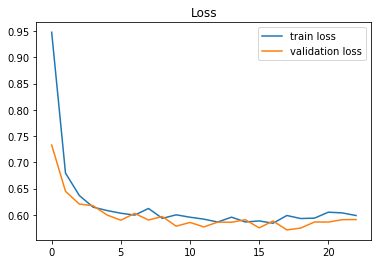

 20%|████████████████▊                                                                   | 1/5 [00:05<00:23,  5.98s/it]

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_493 (Dense)            (None, 32)                37824     
_________________________________________________________________
dropout_111 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_494 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_112 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_495 (Dense)            (None, 1)                 17        
Total params: 38,369
Trainable params: 38,369
Non-trainable params: 0
_________________________________________________________________
Train on 2800 samples, validate on 700 samples
Epoch 1/100
2800/2800 [==============================] - 0s 113us/st

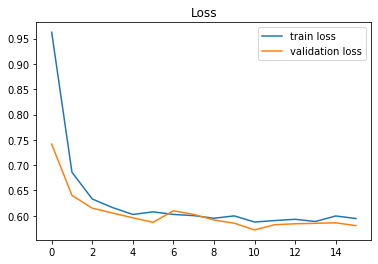

 40%|█████████████████████████████████▌                                                  | 2/5 [00:10<00:16,  5.45s/it]

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_496 (Dense)            (None, 32)                37824     
_________________________________________________________________
dropout_113 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_497 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_114 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_498 (Dense)            (None, 1)                 17        
Total params: 38,369
Trainable params: 38,369
Non-trainable params: 0
_________________________________________________________________
Train on 2800 samples, validate on 700 samples
Epoch 1/100
2800/2800 [==============================] - 0s 106us/st

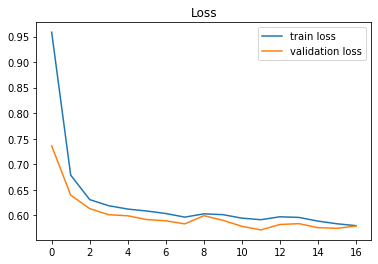

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:15<00:10,  5.49s/it]

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_499 (Dense)            (None, 32)                37824     
_________________________________________________________________
dropout_115 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_500 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_116 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_501 (Dense)            (None, 1)                 17        
Total params: 38,369
Trainable params: 38,369
Non-trainable params: 0
_________________________________________________________________
Train on 2800 samples, validate on 700 samples
Epoch 1/100
2800/2800 [==============================] - 0s 120us/st

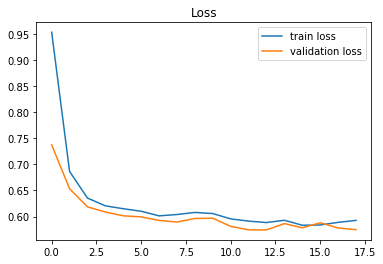

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:20<00:05,  5.35s/it]

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_502 (Dense)            (None, 32)                37824     
_________________________________________________________________
dropout_117 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_503 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_118 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_504 (Dense)            (None, 1)                 17        
Total params: 38,369
Trainable params: 38,369
Non-trainable params: 0
_________________________________________________________________
Train on 2800 samples, validate on 700 samples
Epoch 1/100
2800/2800 [==============================] - 0s 110us/st

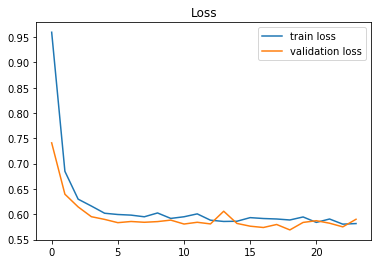

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.32s/it]


In [290]:
for i in tqdm(range(5)):
# Define the number of features
    max_features = X_train.shape[1]

# Define the Model architecture
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(max_features,), kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    # Train the Model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    history = model.fit(X_train, y_train, epochs=100, batch_size=64, 
            validation_data=(X_valid,y_valid), callbacks=[EarlyStopping(patience=5)])

    print(roc_auc_score(y_valid, model.predict(X_valid)))

    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

In [109]:
    # AE기본

# < 구매여부 >
# 중분류: 7431
# 대분류: 7479
# 소분류: 7124
# 중분류 대분류: 7434
# 중분류 소분류: 7531
# 대분류 소분류: 7544
# 대분류 중분류 소분류: 7458, 7500, 7523, 7712

# < 구매건수 >
# 중분류: 0.7008
# 대분류: 0.7051
# 소분류: 0.6393
# 중분류 대분류: 6979
# 중분류 소분류:  
# 대분류 소분류:  
# 대분류 중분류 소분류: 6884

    # Dropout AE(0.3)

# < 구매여부 >
# 중분류: 7414
# 대분류: 
# 소분류: 
# 중분류 대분류: 
# 중분류 소분류: 7485
# 대분류 소분류: 7465
# 대분류 중분류 소분류: 7525

    # Gaussian noise AE

# < 구매여부 >
# 중분류: 
# 대분류: 
# 소분류: 
# 중분류 대분류: 
# 중분류 소분류: 
# 대분류 소분류: 6816
# 대분류 중분류 소분류: 

make submissions

In [ ]:
pred = model.predict(X_test)[:,0]
t = pd.Timestamp.now()
fname = f"ae_submission_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
submissions.to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")